In [1]:
import pandas as pd

user_id = 12120382831
top_artists = pd.read_csv('data/top_artists.csv')
top_tracks = pd.read_csv('data/top_tracks.csv')

In [2]:
top_artists.head()

,user_id,rank,artist,genres,artist_url,timeframe
0,12120382831,1,Jay Chou,c-pop; mandopop; taiwan pop; zhongguo feng,https://open.spotify.com/artist/2elBjNSdBE2Y3f...,Short
1,12120382831,2,Kid Cudi,ohio hip hop; pop rap; rap,https://open.spotify.com/artist/0fA0VVWsXO9YnA...,Short
2,12120382831,3,Joji,alternative r&b; viral pop,https://open.spotify.com/artist/3MZsBdqDrRTJih...,Short
3,12120382831,4,Calvin Harris,dance pop; edm; electro house; house; pop; pop...,https://open.spotify.com/artist/7CajNmpbOovFoO...,Short
4,12120382831,5,Frank Ocean,alternative r&b; hip hop; lgbtq+ hip hop; neo ...,https://open.spotify.com/artist/2h93pZq0e7k5yf...,Short


In [3]:
top_tracks.head()

,user_id,rank,track,artists,album,release_date,track_url,timeframe
0,12120382831,1,安靜,Jay Chou,范特西,2001-09-14,https://open.spotify.com/track/4FOydQ5IdqmdeBg...,Short
1,12120382831,2,With You (Jai Wolf Remix),Dirty South; FMLYBND,With You (The Remixes),2015-04-28,https://open.spotify.com/track/5H2cgEPEJxA72Bq...,Short
2,12120382831,1,安靜,Jay Chou,范特西,2001-09-14,https://open.spotify.com/track/4FOydQ5IdqmdeBg...,Medium
3,12120382831,2,With Me,Sum 41,Underclass Hero,2007-01-01,https://open.spotify.com/track/1OTvWduKQV0MQd2...,Medium
4,12120382831,3,Wake Me up When September Ends,Green Day,American Idiot,2004-09-21,https://open.spotify.com/track/3ZffCQKLFLUvYM5...,Medium


In [93]:
top_artists = top_artists.loc[top_artists['user_id'] == user_id]
top_artists.head()

,user_id,rank,artist,genres,artist_url,timeframe
0,12120382831,1,Jay Chou,c-pop; mandopop; taiwan pop; zhongguo feng,https://open.spotify.com/artist/2elBjNSdBE2Y3f...,Short
1,12120382831,2,Kid Cudi,ohio hip hop; pop rap; rap,https://open.spotify.com/artist/0fA0VVWsXO9YnA...,Short
2,12120382831,3,Joji,alternative r&b; viral pop,https://open.spotify.com/artist/3MZsBdqDrRTJih...,Short
3,12120382831,4,Calvin Harris,dance pop; edm; electro house; house; pop; pop...,https://open.spotify.com/artist/7CajNmpbOovFoO...,Short
4,12120382831,5,Frank Ocean,alternative r&b; hip hop; lgbtq+ hip hop; neo ...,https://open.spotify.com/artist/2h93pZq0e7k5yf...,Short


In [5]:
top_tracks = top_tracks.loc[top_tracks['user_id'] == user_id]
top_tracks.head()

,user_id,rank,track,artists,album,release_date,track_url,timeframe
0,12120382831,1,安靜,Jay Chou,范特西,2001-09-14,https://open.spotify.com/track/4FOydQ5IdqmdeBg...,Short
1,12120382831,2,With You (Jai Wolf Remix),Dirty South; FMLYBND,With You (The Remixes),2015-04-28,https://open.spotify.com/track/5H2cgEPEJxA72Bq...,Short
2,12120382831,1,安靜,Jay Chou,范特西,2001-09-14,https://open.spotify.com/track/4FOydQ5IdqmdeBg...,Medium
3,12120382831,2,With Me,Sum 41,Underclass Hero,2007-01-01,https://open.spotify.com/track/1OTvWduKQV0MQd2...,Medium
4,12120382831,3,Wake Me up When September Ends,Green Day,American Idiot,2004-09-21,https://open.spotify.com/track/3ZffCQKLFLUvYM5...,Medium


In [6]:
def top_to_dict(top_df):
    top_dict = {}
    top_dict['Short'] = top_df.loc[top_df['timeframe'] == 'Short'].to_dict('records')
    top_dict['Medium'] = top_df.loc[top_df['timeframe'] == 'Medium'].to_dict('records')
    top_dict['Long'] = top_df.loc[top_df['timeframe'] == 'Long'].to_dict('records')
    return top_dict

In [9]:
top_artists_dict = top_to_dict(top_artists)
top_tracks_dict = top_to_dict(top_tracks)

In [11]:
top_genres = top_artists[['user_id', 'rank', 'genres', 'timeframe']]
top_genres.head()

,user_id,rank,genres,timeframe
0,12120382831,1,c-pop; mandopop; taiwan pop; zhongguo feng,Short
1,12120382831,2,ohio hip hop; pop rap; rap,Short
2,12120382831,3,alternative r&b; viral pop,Short
3,12120382831,4,dance pop; edm; electro house; house; pop; pop...,Short
4,12120382831,5,alternative r&b; hip hop; lgbtq+ hip hop; neo ...,Short


In [12]:
df = top_genres.loc[top_genres['timeframe'] == 'Short']
df.head()

,user_id,rank,genres,timeframe
0,12120382831,1,c-pop; mandopop; taiwan pop; zhongguo feng,Short
1,12120382831,2,ohio hip hop; pop rap; rap,Short
2,12120382831,3,alternative r&b; viral pop,Short
3,12120382831,4,dance pop; edm; electro house; house; pop; pop...,Short
4,12120382831,5,alternative r&b; hip hop; lgbtq+ hip hop; neo ...,Short


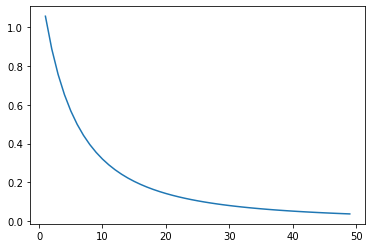

In [67]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(1, 50)
y = 128 / ((x+10)**2)
plt.plot(x, y);

In [68]:
top_g = {}
for _, row in df.iterrows():
    weight = 128
    shift = 10
    points = weight / ((row['rank'] + shift) ** 2)
    genres = row['genres'].split(';')
    for g in genres:
        if g in top_g:
            top_g[g] += points
        else:
            top_g[g] = points

top_g = {k: v for k, v in sorted(top_g.items(), key=lambda item: item[1], reverse=True)}
print(top_g)

{' pop': 3.1840240705446674, ' rap': 2.7520933058660115, ' pop dance': 1.972729022984263, ' edm': 1.6658408839282917, ' hip hop': 1.4005440721917692, ' pop rap': 1.359026552836887, 'alternative r&b': 1.3262853385930309, ' electro house': 1.2730235907222716, ' tropical house': 1.155630034529337, 'c-pop': 1.0578512396694215, ' mandopop': 1.0578512396694215, ' taiwan pop': 1.0578512396694215, ' zhongguo feng': 1.0578512396694215, 'dance pop': 1.0481229528848575, ' house': 0.9713990801109353, ' progressive house': 0.9611429005041063, 'ohio hip hop': 0.8888888888888888, 'chicago rap': 0.7902494331065759, ' electropop': 0.764364093397539, ' viral pop': 0.757396449704142, ' punk': 0.6823533897047903, ' uk dance': 0.6530612244897959, ' lgbtq+ hip hop': 0.5688888888888889, ' neo soul': 0.5688888888888889, ' pop punk': 0.550004974807899, 'hip hop': 0.5315492336742421, ' lo-fi beats': 0.48706969616124923, 'lo-fi beats': 0.4628177618825062, 'chillhop': 0.44317394856179787, 'big room': 0.4377646784

In [75]:
top_g_df = pd.DataFrame.from_dict(top_g, orient='index').reset_index()
top_g_df['rank'] = top_g_df.index + 1
top_g_df = top_g_df.rename(columns={'index': 'genre'})
top_g_df = top_g_df[['rank', 'genre']]
top_g_df

,rank,genre
0,1,pop
1,2,rap
2,3,pop dance
3,4,edm
4,5,hip hop
...,...,...
80,81,canadian hip hop
81,82,toronto rap
82,83,deep big room
83,84,future house


In [102]:
top_artists_dict

{'Short': [{'user_id': 12120382831,
   'rank': 1,
   'artist': 'Jay Chou',
   'genres': 'c-pop; mandopop; taiwan pop; zhongguo feng',
   'artist_url': 'https://open.spotify.com/artist/2elBjNSdBE2Y3f0j1mjrql',
   'timeframe': 'Short'},
  {'user_id': 12120382831,
   'rank': 2,
   'artist': 'Kid Cudi',
   'genres': 'ohio hip hop; pop rap; rap',
   'artist_url': 'https://open.spotify.com/artist/0fA0VVWsXO9YnASrzqfmYu',
   'timeframe': 'Short'},
  {'user_id': 12120382831,
   'rank': 3,
   'artist': 'Joji',
   'genres': 'alternative r&b; viral pop',
   'artist_url': 'https://open.spotify.com/artist/3MZsBdqDrRTJihTHQrO6Dq',
   'timeframe': 'Short'},
  {'user_id': 12120382831,
   'rank': 4,
   'artist': 'Calvin Harris',
   'genres': 'dance pop; edm; electro house; house; pop; pop dance; progressive house; uk dance',
   'artist_url': 'https://open.spotify.com/artist/7CajNmpbOovFoOoasH2HaY',
   'timeframe': 'Short'},
  {'user_id': 12120382831,
   'rank': 5,
   'artist': 'Frank Ocean',
   'genres

In [113]:
LIMIT = 50

def get_top_genres_df(top_artists, weight=128, shift=10):
    df_genre = pd.DataFrame(columns=['user_id', 'rank', 'genre', 'timeframe'])
    user_id = top_artists['Short'][0]['user_id']
    top_genres_list = []
    for timeframe in ['Short', 'Medium', 'Long']:
        top_genres = {}
        for artist in top_artists[timeframe]:
            try:
                points = weight / ((artist['rank'] + shift) ** 2)
                genres = artist['genres'].split(';')
                for genre in genres:
                    genre = genre.strip().title()
                    if genre in top_genres:
                        top_genres[genre] += points
                    else:
                        top_genres[genre] = points
            except:
                pass
        top_genres = {k: v for k, v in sorted(top_genres.items(), key=lambda item: item[1], reverse=True)}
        top_genres = [g for g in list(top_genres.keys())[:LIMIT]]
        user_ids = [user_id for i in range(len(top_genres))]
        ranks = [i for i in range(1, len(top_genres)+1)]
        timeframes = [timeframe for i in range(len(top_genres))]
        df_genre = df_genre.append(pd.DataFrame(list(map(list, zip(*[user_ids, ranks, top_genres, timeframes]))), \
                                                columns=['user_id', 'rank', 'genre', 'timeframe']))
    return df_genre.reset_index(drop=True)

In [114]:
top_genres = get_top_genres_df(top_artists_dict)
top_genres

,user_id,rank,genre,timeframe
0,12120382831,1,Pop,Short
1,12120382831,2,Rap,Short
2,12120382831,3,Edm,Short
3,12120382831,4,Pop Dance,Short
4,12120382831,5,Hip Hop,Short
...,...,...,...,...
145,12120382831,46,Neo Soul,Long
146,12120382831,47,Viral Pop,Long
147,12120382831,48,Dark Trap,Long
148,12120382831,49,Ohio Hip Hop,Long


In [115]:
top_genres['user_id'][0]

12120382831

In [107]:
top_genres.to_csv('data/top_genres.csv', index=False)